In [1]:
# 采用Transfer Learning,对VGG16进行特征抽取
# 即对VGG16中Flatten后面的神经层全部去掉，换上我们自己的神经层，这个行为叫做特征抽取
# 注：VGG16中，前面的多重卷积层和池化层对图像特征已做了很好的提取，此部分可以直接使用

# 通过代码来初始化一个VGG16网络实例
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 下载vgg16模型预训练权重，将之放到~/.keras/model/下面，
# 这样在keras导入vgg16的时候就不会联网下载

# weight参数告诉程序将网络的卷积层和max pooling层对应的参数传递过来，
# 并将它们初始化成对应的网络层次
# include_top表示是否也要把Flatten()后面的网络层也下载过来
# input_shape告诉网络，我们输入图片的大小是150*150像素，每个像素由[R, G, B]三个值表示
conv_base = VGG16(weights="imagenet", include_top=False,input_shape = (150,150,3))

conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [15]:
# 接下来我们将把自己的图片读进来，
# 把图片喂给上面网络，让它把图片的隐含信息给抽取出来
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "C:/Users/hh/Desktop/Kaggle/2.0 CatdogNet/input/TE_Pd_train"
train_dir = os.path.join(base_dir,"train")
validation_dir = os.path.join(base_dir,"validation")
test_dir = os.path.join(base_dir,"test")

datagen = ImageDataGenerator(rescale = 1. / 255)
batch_size = 9

# generator 实际上是将数据批量读入内存，使得代码能以for in 的方式去方便的访问
# 利用VGG16的卷积层把图片的特征抽取出来
def extract_features(directory,sample_count):
    features = np.zeros(shape = (sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,target_size = (150,150),
                                           batch_size = batch_size,
                                           class_mode = "binary")
    i = 0
    for inputs_batch,labels_batch in generator:
        # 把图片输入VGG16层的卷积层，让它把图片信息抽取出来
        features_batch = conv_base.predict(inputs_batch)
        # feature_batch是4*4*512结构的
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # for in 在generator上的循环是无限的，因此需要主动break掉
            break
        return features,labels
# extract_features返回数据格式为（samples，4,4,512）
train_features,train_labels = extract_features(train_dir,36)
validation_features,validation_labels = extract_features(validation_dir,12)
test_features,test_labels = extract_features(test_dir,12)

Found 72 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [18]:
# 上面代码利用VGG16的卷积层把图片的特征抽取出来，
# 接下来就可以把抽取的特征输入到我们自己的神经层中进行分类
train_features = np.reshape(train_features,(36,4*4*512))
validation_features = np.reshape(validation_features,(12,4*4*512))
test_features = np.reshape(test_features,(12,4*4*512))

from keras import models
from keras import layers
from keras import optimizers

# 构造新的网络对输出层进行分类
model = models.Sequential()
model.add(layers.Dense(256,activation = "relu",input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = "binary_crossentropy",
             metrics = ["acc"])
history = model.fit(train_features,train_labels,epochs = 200,batch_size = 12,
                   validation_data = (validation_features,validation_labels))

Train on 36 samples, validate on 12 samples
Epoch 1/200
36/36 [==============================] - 0s 13ms/step - loss: 0.7094 - acc: 0.6667 - val_loss: 0.6812 - val_acc: 0.8333
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6612 - acc: 0.9722 - val_loss: 0.6319 - val_acc: 0.8333
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6499 - acc: 0.9722 - val_loss: 0.5879 - val_acc: 0.8333
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6074 - acc: 0.9722 - val_loss: 0.5549 - val_acc: 0.9167
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6195 - acc: 0.9722 - val_loss: 0.5223 - val_acc: 0.9167
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6439 - acc: 0.9167 - val_loss: 0.4963 - val_acc: 0.9167
Epoch 7/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5882 - acc: 1.0000 - val_loss: 0.4721 - val_acc: 0.9167
Epoch 8/200
36/36 [===================

Epoch 63/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5134 - acc: 1.0000 - val_loss: 0.1938 - val_acc: 1.0000
Epoch 64/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5127 - acc: 1.0000 - val_loss: 0.1937 - val_acc: 1.0000
Epoch 65/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5125 - acc: 1.0000 - val_loss: 0.1953 - val_acc: 1.0000
Epoch 66/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5123 - acc: 1.0000 - val_loss: 0.1933 - val_acc: 1.0000
Epoch 67/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5124 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 1.0000
Epoch 68/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5122 - acc: 1.0000 - val_loss: 0.1899 - val_acc: 1.0000
Epoch 69/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5123 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 1.0000
Epoch 70/200
36/36 [==============================] - 0s 2ms/step - loss: 0.

Epoch 125/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5042 - acc: 1.0000 - val_loss: 0.1716 - val_acc: 1.0000
Epoch 126/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5039 - acc: 1.0000 - val_loss: 0.1715 - val_acc: 1.0000
Epoch 127/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5039 - acc: 1.0000 - val_loss: 0.1714 - val_acc: 1.0000
Epoch 128/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5040 - acc: 1.0000 - val_loss: 0.1710 - val_acc: 1.0000
Epoch 129/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5033 - acc: 1.0000 - val_loss: 0.1708 - val_acc: 1.0000
Epoch 130/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5037 - acc: 1.0000 - val_loss: 0.1712 - val_acc: 1.0000
Epoch 131/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5027 - acc: 1.0000 - val_loss: 0.1709 - val_acc: 1.0000
Epoch 132/200
36/36 [==============================] - 0s 2ms/step - 

36/36 [==============================] - 0s 3ms/step - loss: 0.4948 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 1.0000
Epoch 187/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4947 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 1.0000
Epoch 188/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4950 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 1.0000
Epoch 189/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4947 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 1.0000
Epoch 190/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4938 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 1.0000
Epoch 191/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4938 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 1.0000
Epoch 192/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4946 - acc: 1.0000 - val_loss: 0.1657 - val_acc: 1.0000
Epoch 193/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4931 -

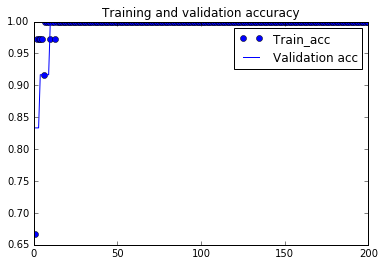

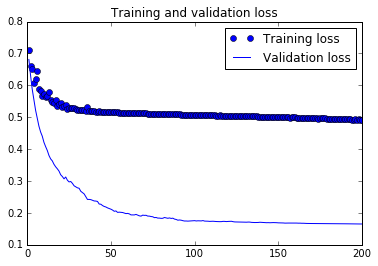

In [19]:
# 绘制曲线
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,"bo",label = "Train_acc")
plt.plot(epochs,val_acc,"b",label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,"bo",label = "Training loss")
plt.plot(epochs,val_loss,"b",label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()